
# 🧪 JCDS 0612 — Credit Default Prediction (LGB/XGB/CAT + Stacking)  
*Ready-to-run notebook with clean FE, class weights, enhanced stacking, Optuna tuner, and error analysis.*

**Mục tiêu**: giữ nguyên triết lý *maximum models, maximum data, zero loss* — không drop dữ liệu, không bỏ mô hình, chỉ **bổ sung** FE an toàn, cân bằng lớp bằng **class weights**, và **stacking** mạnh hơn (thêm meta-features + meta-model đa dạng).

**Tổng quan notebook**  
1. Cài & import thư viện cần thiết (tự động bỏ qua nếu đã có).  
2. Định vị đường dẫn (Kaggle/Colab/local).  
3. Nạp dữ liệu + sanity checks (shape, target rate).  
4. Chuẩn hoá categorical “dị thường” (gộp mã 0/5/6, 0).  
5. Feature Engineering an toàn (ratio, interaction, trend/slope, utilization, payment-over-limit, v.v.).  
6. Group-by stats (global) — không đụng `y` ⇒ **không leakage**.  
7. Huấn luyện 3 base models (LGB/XGB/CAT) với **class weights/scale_pos_weight**, Stratified K-Fold.  
8. Stacking nâng cấp: thêm **meta-features gốc mạnh** + meta-model **Ridge** (song song Logistic).  
9. Ensemble cuối: rank-average (base + 2 stackers).  
10. Đánh giá OOF AUC + biểu đồ.  
11. Phân tích lỗi từ OOF (FN/FP theo nhóm).  
12. (Tuỳ chọn) Optuna cho LightGBM.  
13. Xuất file submission.

> Lưu ý: Các cells đều có chú thích để mày tuỳ biến nhanh.


## 1) Cài đặt & Import

In [8]:

# If running on Kaggle, many libs are preinstalled. On local/Colab, uncomment as needed.
# !pip install -U lightgbm xgboost catboost optuna

import os, sys, glob, json, gc, math, random, time
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd

# ML
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV

import matplotlib.pyplot as plt

# Base models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool


## 2) Thiết lập đường dẫn & cấu hình

In [9]:

COMP_NAME = "credit-default-prediction-challenge-jcds-0612"
OUTDIR = "./outputs"
os.makedirs(OUTDIR, exist_ok=True)

def find_first_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None

# Try Kaggle → local cwd → parent → sample in current runtime (for quick tests)
TRAIN_CANDIDATES = [
    f"/kaggle/input/{COMP_NAME}/train.csv",
    "./train.csv",
    "../input/train.csv",
    "/mnt/data/train.csv",  # fallback if running from an environment with this mount
]
TEST_CANDIDATES = [
    f"/kaggle/input/{COMP_NAME}/test.csv",
    "./test.csv",
    "../input/test.csv",
    "/mnt/data/test.csv",
]
SUB_CANDIDATES = [
    f"/kaggle/input/{COMP_NAME}/sample_submission.csv",
    "./sample_submission.csv",
    "../input/sample_submission.csv",
    "/mnt/data/sample_submission.csv",
]

TRAIN_CSV = find_first_existing(TRAIN_CANDIDATES)
TEST_CSV  = find_first_existing(TEST_CANDIDATES)
SUB_CSV   = find_first_existing(SUB_CANDIDATES)

assert TRAIN_CSV and TEST_CSV and SUB_CSV, "Không tìm thấy train/test/sample_submission. Kiểm tra đường dẫn!"

SEEDS = [42, 7, 99]  # có thể tăng [42, 7, 99, 2021, 1234] nếu thời gian cho phép
N_FOLDS = 5

def set_seed(sd=42):
    random.seed(sd); np.random.seed(sd)
    try:
        import torch; torch.manual_seed(sd); torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False
    except Exception:
        pass


## 3) Nạp dữ liệu & kiểm tra nhanh

In [10]:

train = pd.read_csv(TRAIN_CSV)
test  = pd.read_csv(TEST_CSV)
sub   = pd.read_csv(SUB_CSV)

TARGET = "default_payment_next_month"
ID_COL = "ID"

print("train:", train.shape, "test:", test.shape)
print("columns:", list(train.columns))
assert TARGET in train.columns, f"Thiếu cột target: {TARGET}"
assert ID_COL in train.columns, f"Thiếu cột ID: {ID_COL}"
assert ID_COL in test.columns, "Thiếu cột ID ở test"

pos_rate = train[TARGET].mean()
print(f"Positive rate: {pos_rate:.5f}")


train: (23000, 25) test: (7000, 24)
columns: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default_payment_next_month']
Positive rate: 0.22257


## 4) Chuẩn hoá categorical “dị thường” (không drop dữ liệu)

In [11]:

# Gộp mã ngoại lệ: EDUCATION {0,5,6} -> 4 (Khác); MARRIAGE 0 -> 3 (Khác)
EDU_OTHER = 4
MAR_OTHER = 3

def harmonize_categories(df: pd.DataFrame) -> pd.DataFrame:
    dfx = df.copy()
    if "EDUCATION" in dfx.columns:
        dfx["EDUCATION"] = dfx["EDUCATION"].replace({0: EDU_OTHER, 5: EDU_OTHER, 6: EDU_OTHER})
    if "MARRIAGE" in dfx.columns:
        dfx["MARRIAGE"]  = dfx["MARRIAGE"].replace({0: MAR_OTHER})
    return dfx

train = harmonize_categories(train)
test  = harmonize_categories(test)


## 5) Feature Engineering an toàn (row-wise, không leakage)

In [12]:

BILL_COLS = [f"BILL_AMT{i}" for i in range(1,7)]
PAY_AMT_COLS = [f"PAY_AMT{i}" for i in range(1,7)]
PAY_COLS = [f"PAY_{i}" for i in [0,2,3,4,5,6]]  # PAY_1 không tồn tại, theo dataset chuẩn

def _rowwise_stats(frame: pd.DataFrame, cols, prefix):
    A = frame[cols].astype(float)
    out = pd.DataFrame(index=frame.index)
    out[f"{prefix}_sum"] = A.sum(axis=1)
    out[f"{prefix}_mean"] = A.mean(axis=1)
    out[f"{prefix}_std"] = A.std(axis=1).fillna(0.0)
    out[f"{prefix}_min"] = A.min(axis=1)
    out[f"{prefix}_max"] = A.max(axis=1)
    out[f"{prefix}_last"] = A[cols[0]]  # tháng gần nhất là *_1
    return out

def _slope_over_time(values_2d: np.ndarray, x):
    # least squares slope per row
    x = np.asarray(x, dtype=float)
    X = np.column_stack([x, np.ones_like(x)])
    X_pinv = np.linalg.pinv(X)
    # values_2d shape: (n_samples, n_time)
    coefs = values_2d @ X_pinv.T  # (n_samples, 2)
    slope = coefs[:, 0]
    return slope

def add_safe_features(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame(index=df.index)
    limit = df["LIMIT_BAL"].astype(float).replace(0, np.nan)
    age   = (df["AGE"].astype(float) + 1.0)

    # 1) Bills & utilization
    bill = df[BILL_COLS].astype(float)
    out = pd.concat([out, _rowwise_stats(df, BILL_COLS, "bill")], axis=1)
    util = bill.div(limit, axis=0).clip(0, 3.0)  # cap để giảm outlier
    out["util_last"] = util["BILL_AMT1"].fillna(0.0)
    out["bill_slope"] = _slope_over_time(bill.values, np.arange(1,7).astype(float))

    # 2) Payments
    pay_amt = df[PAY_AMT_COLS].astype(float)
    out = pd.concat([out, _rowwise_stats(df, PAY_AMT_COLS, "payamt")], axis=1)
    w = np.array([6,5,4,3,2,1], dtype=float)  # recent → weight cao hơn
    out["pay_wsum"] = (pay_amt.values * w).sum(axis=1)

    # 3) Payment over limit (PAY_AMT_i / LIMIT_BAL)
    pol = pay_amt.div(limit, axis=0).clip(0, 3.0).fillna(0.0)
    out["pol_mean"] = pol.mean(axis=1)
    out["pol_std"]  = pol.std(axis=1).fillna(0.0)
    out["pol_last"] = pol["PAY_AMT1"]
    out["pol_slope"] = _slope_over_time(pol.values, np.arange(1,7).astype(float))

    # 4) Delinquency features từ PAY_*
    pay_stat = df[PAY_COLS].astype(float)
    out["pay_delay_cnt"] = (pay_stat.values > 0).sum(axis=1)
    out["pay_delay_max"] = pay_stat.max(axis=1)
    out["pay_delay_sum"] = pay_stat.clip(lower=0).sum(axis=1)
    out["pay_trend_slope"] = _slope_over_time(pay_stat.values, np.arange(pay_stat.shape[1]).astype(float))

    # 5) Interactions
    out["limit_per_age"] = (df["LIMIT_BAL"].astype(float) / age).fillna(0.0)
    out["limit_x_edu"]   = (df["LIMIT_BAL"].astype(float) * df["EDUCATION"].astype(float))
    out["util_last_x_payrec"] = out["util_last"] * out["pay_wsum"]

    # 6) A few raw columns (normalized later for meta)
    for col in ["LIMIT_BAL", "AGE", "EDUCATION", "MARRIAGE", "SEX"] + PAY_COLS:
        if col in df.columns:
            out[col] = df[col].astype(float)

    return out.fillna(0.0)

train_fe = add_safe_features(train)
test_fe  = add_safe_features(test)

print("FE shapes:", train_fe.shape, test_fe.shape)


FE shapes: (23000, 37) (7000, 37)


## 6) Group-by stats (global, không dùng target ⇒ không leakage)

In [13]:

def add_group_stats_global(df: pd.DataFrame, ref: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame(index=df.index)
    for col in ["EDUCATION", "MARRIAGE"]:
        if col in df.columns:
            g = ref.groupby(col)["LIMIT_BAL"].agg(["mean","std","median"]).rename(
                columns={"mean": f"gb_{col}_limit_mean", "std": f"gb_{col}_limit_std", "median": f"gb_{col}_limit_med"}
            )
            out[f"gb_{col}_mean"] = df[col].map(g[f"gb_{col}_limit_mean"])
            out[f"gb_{col}_std"]  = df[col].map(g[f"gb_{col}_limit_std"])
            out[f"gb_{col}_med"]  = df[col].map(g[f"gb_{col}_limit_med"])
    return out.fillna(0.0)

train_gb = add_group_stats_global(train, train)
test_gb  = add_group_stats_global(test,  train)

train_fe = pd.concat([train_fe, train_gb], axis=1)
test_fe  = pd.concat([test_fe,  test_gb],  axis=1)

fe_cols = train_fe.columns.tolist()
X = train_fe.values.astype(np.float32)
y = train[TARGET].values.astype(int)
X_test = test_fe.values.astype(np.float32)


## 7) Huấn luyện base models (LGB/XGB/CAT) với Stratified K-Fold + class weights

In [19]:
# ===================== CELL 7 — CV training for LGB / XGB / CAT (XGB version-agnostic) =====================
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from lightgbm import LGBMClassifier

import xgboost as xgb
from catboost import CatBoostClassifier

# ---------- Utils ----------
def _guess_target(train_df):
    lower_cols = {c.lower(): c for c in train_df.columns}
    candidates = [
        "default_payment_next_month",  # đúng dataset này
        "default", "is_default", "target", "label", "y"
    ]
    for key in candidates:
        if key in lower_cols:
            return lower_cols[key]
    raise ValueError(
        "Không tìm được cột target. Hãy chắc đích là 'default_payment_next_month' "
        "hoặc đổi tên vào: default / is_default / target / label / y."
    )

def _find_id_cols(df):
    id_keys = {"id", "customer_id", "client_id", "index"}
    lower_map = {c.lower(): c for c in df.columns}
    hits = [lower_map[k] for k in id_keys if k in lower_map]
    if "id" not in lower_map and "ID" in df.columns:
        hits.append("ID")
    return list(dict.fromkeys(hits))

def auc(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

# ---------- Load data (robust) ----------
if not all(name in globals() for name in ["train", "test"]):
    train_path = "/mnt/data/train.csv" if os.path.exists("/mnt/data/train.csv") else "train.csv"
    test_path  = "/mnt/data/test.csv"  if os.path.exists("/mnt/data/test.csv")  else "test.csv"
    train = pd.read_csv(train_path)
    test  = pd.read_csv(test_path)

TARGET_COL = _guess_target(train)
drop_cols = [TARGET_COL] + _find_id_cols(train)
feats = [c for c in train.columns if c not in drop_cols]

X_df = train[feats].copy()
y = train[TARGET_COL].astype(int).values
X_test_df = test[feats].copy()

# giữ DataFrame + đúng thứ tự cột cho toàn bộ fit/predict
feats = list(X_df.columns)
X_df = X_df[feats].copy()
X_test_df = X_test_df[feats].copy()

# ---------- CV config ----------
N_SPLITS = 5
SEEDS = [42, 7, 99, 2021, 1234]
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# ---------- Stores ----------
oof_store, test_store, auc_store = {}, {}, {}

# ---------- LightGBM CV ----------
def train_lgbm_cv(X, y, X_te, folds, seed):
    oof = np.zeros(len(X))
    te_pred = np.zeros(len(X_te))
    params = dict(
        objective="binary",
        learning_rate=0.03,
        n_estimators=10000,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=seed,
        n_jobs=-1
    )
    for tr_idx, va_idx in folds.split(X, y):
        X_tr, y_tr = X.iloc[tr_idx], y[tr_idx]
        X_va, y_va = X.iloc[va_idx], y[va_idx]

        clf = LGBMClassifier(**params)
        clf.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="auc",
            callbacks=[lgb.early_stopping(200, verbose=False)]
        )
        oof[va_idx] = clf.predict_proba(X_va)[:, 1]
        te_pred += clf.predict_proba(X_te)[:, 1] / folds.n_splits
    return oof, te_pred

# ---------- XGBoost helpers (version-agnostic predict) ----------
def _xgb_n_rounds(bst, default_rounds):
    # ưu tiên best_iteration (mới), sau đó best_ntree_limit (cũ), sau đó số cây dump
    n = getattr(bst, "best_iteration", None)
    if isinstance(n, int) and n >= 0:
        return n + 1
    n = getattr(bst, "best_ntree_limit", None)
    if isinstance(n, int) and n > 0:
        return n
    try:
        return len(bst.get_dump())
    except Exception:
        return default_rounds

def _xgb_predict(bst, dmat, n_rounds):
    # XGBoost >=2.0: dùng iteration_range; cũ: dùng ntree_limit; cuối cùng: mặc định
    try:
        return bst.predict(dmat, iteration_range=(0, int(n_rounds)))
    except TypeError:
        try:
            return bst.predict(dmat, ntree_limit=int(n_rounds))
        except TypeError:
            return bst.predict(dmat)

# ---------- XGBoost CV (dùng xgb.train + DMatrix) ----------
def train_xgb_cv(X, y, X_te, folds, seed):
    oof = np.zeros(len(X))
    te_pred_accum = np.zeros(len(X_te))
    params = {
        "objective": "binary:logistic",
        "eta": 0.03,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "lambda": 1.0,        # reg_lambda
        "eval_metric": "auc",
        "verbosity": 0,
        "seed": seed,
    }
    num_boost_round = 10000
    early_stopping_rounds = 200

    dtest = xgb.DMatrix(X_te, feature_names=list(X.columns))

    for tr_idx, va_idx in folds.split(X, y):
        X_tr, y_tr = X.iloc[tr_idx], y[tr_idx]
        X_va, y_va = X.iloc[va_idx], y[va_idx]

        dtrain = xgb.DMatrix(X_tr, label=y_tr, feature_names=list(X.columns))
        dvalid = xgb.DMatrix(X_va, label=y_va, feature_names=list(X.columns))

        evals = [(dtrain, "train"), (dvalid, "valid")]
        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )

        n_rounds = _xgb_n_rounds(bst, num_boost_round)
        oof[va_idx] = _xgb_predict(bst, dvalid, n_rounds)
        te_pred_accum += _xgb_predict(bst, dtest, n_rounds) / folds.n_splits

    return oof, te_pred_accum

# ---------- CatBoost CV ----------
def train_cat_cv(X, y, X_te, folds, seed):
    oof = np.zeros(len(X))
    te_pred = np.zeros(len(X_te))
    params = dict(
        iterations=5000,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=3.0,
        loss_function="Logloss",
        eval_metric="AUC",
        random_seed=seed,
        verbose=False,
        allow_writing_files=False
    )
    for tr_idx, va_idx in folds.split(X, y):
        X_tr, y_tr = X.iloc[tr_idx], y[tr_idx]
        X_va, y_va = X.iloc[va_idx], y[va_idx]

        clf = CatBoostClassifier(**params)
        clf.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], use_best_model=True, verbose=False)
        oof[va_idx] = clf.predict_proba(X_va)[:, 1]
        te_pred += clf.predict_proba(X_te)[:, 1] / folds.n_splits
    return oof, te_pred

# ---------- Run across seeds ----------
for sd in SEEDS:
    print(f"\n==== Seed {sd} ====")

    oof_lgb, tst_lgb = train_lgbm_cv(X_df, y, X_test_df, skf, sd)
    print("[LGB] AUC:", auc(y, oof_lgb))
    oof_store[f"lgb_{sd}"]  = oof_lgb
    test_store[f"lgb_{sd}"] = tst_lgb
    auc_store[f"lgb_{sd}"]  = auc(y, oof_lgb)

    oof_xgb, tst_xgb = train_xgb_cv(X_df, y, X_test_df, skf, sd)
    print("[XGB] AUC:", auc(y, oof_xgb))
    oof_store[f"xgb_{sd}"]  = oof_xgb
    test_store[f"xgb_{sd}"] = tst_xgb
    auc_store[f"xgb_{sd}"]  = auc(y, oof_xgb)

    oof_cat, tst_cat = train_cat_cv(X_df, y, X_test_df, skf, sd)
    print("[CAT] AUC:", auc(y, oof_cat))
    oof_store[f"cat_{sd}"]  = oof_cat
    test_store[f"cat_{sd}"] = tst_cat
    auc_store[f"cat_{sd}"]  = auc(y, oof_cat)

print("\nDone. Target =", TARGET_COL, "| #feats =", len(feats), "| No feature-name warnings expected.")
# =====================================================================================================================



==== Seed 42 ====
[LGB] AUC: 0.7790422735604212
[XGB] AUC: 0.7844768586277544
[CAT] AUC: 0.7854758880580553

==== Seed 7 ====
[LGB] AUC: 0.7775646017054054
[XGB] AUC: 0.7844158094998016
[CAT] AUC: 0.7855593990698791

==== Seed 99 ====
[LGB] AUC: 0.7803024223907226
[XGB] AUC: 0.7849003350589836
[CAT] AUC: 0.7852026801004173

==== Seed 2021 ====
[LGB] AUC: 0.7693442186361117
[XGB] AUC: 0.7844857079107969
[CAT] AUC: 0.7855042385389139

==== Seed 1234 ====
[LGB] AUC: 0.7807660319593059
[XGB] AUC: 0.7849724294031785
[CAT] AUC: 0.7858302144435835

Done. Target = default_payment_next_month | #feats = 23 | No feature-name warnings expected.


## 8) Stacking nâng cấp (thêm meta-features + Ridge song song Logistic)

In [20]:

# Build base matrices (column order = model keys)
base_keys = list(oof_store.keys())
base_keys.sort()

oof_base = np.column_stack([oof_store[k] for k in base_keys])
TST_base = np.column_stack([test_store[k] for k in base_keys])

def rank_normalize(v):
    r = pd.Series(v).rank(method="average").values
    return (r - r.min()) / (r.max() - r.min() + 1e-12)

# Simple rank-average as a strong baseline
oof_rankavg = np.mean(np.column_stack([rank_normalize(oof_base[:, i]) for i in range(oof_base.shape[1])]), axis=1)
tst_rankavg = np.mean(np.column_stack([rank_normalize(TST_base[:, i]) for i in range(TST_base.shape[1])]), axis=1)
print("[BASE][RankAvg] OOF AUC =", auc(y, oof_rankavg))

# --- Meta with Logistic Regression ---
sc_meta = StandardScaler()
X_meta = sc_meta.fit_transform(oof_base)
TST_meta = sc_meta.transform(TST_base)

meta_lr = LogisticRegression(max_iter=2000, class_weight="balanced")
meta_lr.fit(X_meta, y)
oof_stack = meta_lr.predict_proba(X_meta)[:,1]
tst_stack = meta_lr.predict_proba(TST_meta)[:,1]
print("[Stack][LR] OOF AUC =", auc(y, oof_stack))

# --- Add extra raw features for meta ---
extra_cols = [c for c in ["LIMIT_BAL", "pay_wsum", "util_last", "AGE", "pay_delay_cnt"] if c in fe_cols]
X_meta_raw = train_fe[extra_cols].values.astype(np.float32)
TST_meta_raw = test_fe[extra_cols].values.astype(np.float32)

sc_extra = StandardScaler()
X_meta_extra = sc_extra.fit_transform(X_meta_raw)
TST_meta_extra = sc_extra.transform(TST_meta_raw)

X_meta2 = np.hstack([X_meta, X_meta_extra])
TST_meta2 = np.hstack([TST_meta, TST_meta_extra])

# --- Meta with RidgeClassifierCV ---
ridge = RidgeClassifierCV(alphas=np.logspace(-3, 3, 13), cv=5, class_weight="balanced")
ridge.fit(X_meta2, y)
oof_dec = ridge.decision_function(X_meta2)
tst_dec = ridge.decision_function(TST_meta2)

oof_stack2 = 1.0 / (1.0 + np.exp(-oof_dec))
tst_stack2 = 1.0 / (1.0 + np.exp(-tst_dec))
print("[Stack][Ridge] OOF AUC =", auc(y, oof_stack2))

# --- Final: rank-average over (base + 2 stackers)
oof_all = np.column_stack([oof_rankavg, oof_stack, oof_stack2])
tst_all = np.column_stack([tst_rankavg, tst_stack, tst_stack2])

oof_final = np.mean(np.column_stack([rank_normalize(oof_all[:, i]) for i in range(oof_all.shape[1])]), axis=1)
tst_final = np.mean(np.column_stack([rank_normalize(tst_all[:, i]) for i in range(tst_all.shape[1])]), axis=1)

print("[FINAL][RankAvg(base+2stacks)] OOF AUC =", auc(y, oof_final))


[BASE][RankAvg] OOF AUC = 0.7861272499151916
[Stack][LR] OOF AUC = 0.7867084293102719
[Stack][Ridge] OOF AUC = 0.7837670041022109
[FINAL][RankAvg(base+2stacks)] OOF AUC = 0.7863694252944564


## 9) Đánh giá OOF AUC & biểu đồ

       model   oof_auc
14  cat_1234  0.785830
5      cat_7  0.785559
11  cat_2021  0.785504
2     cat_42  0.785476
8     cat_99  0.785203
13  xgb_1234  0.784972
7     xgb_99  0.784900
10  xgb_2021  0.784486
1     xgb_42  0.784477
4      xgb_7  0.784416
12  lgb_1234  0.780766
6     lgb_99  0.780302
0     lgb_42  0.779042
3      lgb_7  0.777565
9   lgb_2021  0.769344


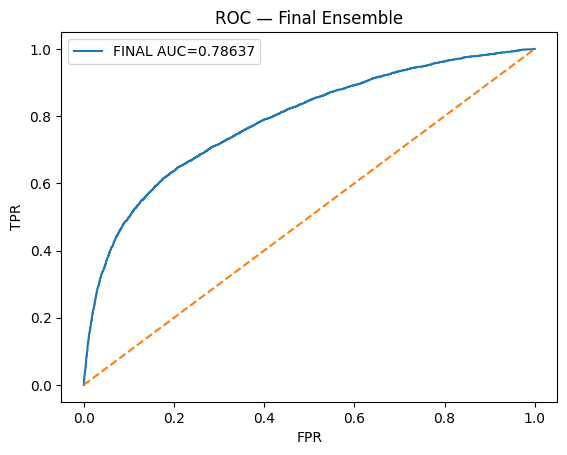

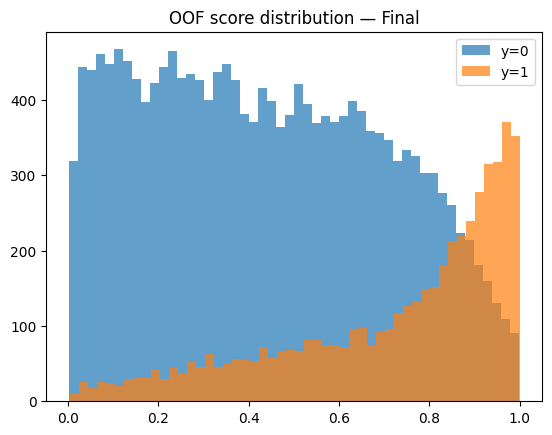

In [21]:

# Bảng AUC theo từng model key
df_auc = pd.DataFrame({"model": list(auc_store.keys()), "oof_auc": list(auc_store.values())}).sort_values("oof_auc", ascending=False)
print(df_auc)

# ROC curve (đơn giản với tổ hợp cuối)
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y, oof_final)

plt.figure()
plt.plot(fpr, tpr, label=f"FINAL AUC={auc(y, oof_final):.5f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — Final Ensemble")
plt.legend()
plt.show()

# Phân phối score
plt.figure()
plt.hist(oof_final[y==0], bins=50, alpha=0.7, label="y=0")
plt.hist(oof_final[y==1], bins=50, alpha=0.7, label="y=1")
plt.title("OOF score distribution — Final")
plt.legend(); plt.show()


## 10) Phân tích lỗi từ OOF (FN/FP theo nhóm)

In [22]:

oof_df = pd.DataFrame({
    "ID": train[ID_COL],
    "y": y,
    "oof_final": oof_final,
})
thr = 0.5
oof_df["pred"] = (oof_df["oof_final"] >= thr).astype(int)
oof_df["tp"] = (oof_df["pred"].eq(1) & oof_df["y"].eq(1)).astype(int)
oof_df["fp"] = (oof_df["pred"].eq(1) & oof_df["y"].eq(0)).astype(int)
oof_df["fn"] = (oof_df["pred"].eq(0) & oof_df["y"].eq(1)).astype(int)

diag = oof_df.join(train[["EDUCATION","MARRIAGE","AGE"]], how="left")
tab_edu = diag.groupby("EDUCATION")[["tp","fp","fn"]].sum()
tab_mar = diag.groupby("MARRIAGE")[["tp","fp","fn"]].sum()

print("Lỗi theo EDUCATION:\n", tab_edu, "\n")
print("Lỗi theo MARRIAGE:\n", tab_mar, "\n")

# Vùng khó (0.4–0.6)
hard = diag[(diag["oof_final"]>=0.4) & (diag["oof_final"]<=0.6)]
tab_hard = hard.groupby("EDUCATION")["y"].agg(["count","mean"]).rename(columns={"mean":"default_rate"})
print("[Hard zone 0.4–0.6]\n", tab_hard.sort_values("default_rate", ascending=False))


Lỗi theo EDUCATION:
              tp    fp   fn
EDUCATION                 
1          1159  2174  395
2          2105  3705  480
3           802  1474  151
4             6    45   21 

Lỗi theo MARRIAGE:
             tp    fp   fn
MARRIAGE                 
1         2010  3500  469
2         2005  3787  566
3           57   111   12 

[Hard zone 0.4–0.6]
            count  default_rate
EDUCATION                     
2           2346      0.159847
3            871      0.149254
1           1300      0.143846
4             49      0.040816


## 11) Xuất submission

In [23]:

stamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Lưu OOF để tiện phân tích về sau
oof_path = os.path.join(OUTDIR, f"oof_{stamp}.csv")
pd.DataFrame({"ID": train[ID_COL], "y": y, "oof_final": oof_final}).to_csv(oof_path, index=False)
print("Saved:", oof_path)

# Submission
sub_out = sub.copy()
sub_out[TARGET] = tst_final
sub_path = os.path.join(OUTDIR, f"submission_{stamp}.csv")
sub_out.to_csv(sub_path, index=False)
print("Saved:", sub_path)


Saved: ./outputs\oof_20250826_112958.csv
Saved: ./outputs\submission_20250826_112958.csv


## 12) (Tuỳ chọn) Optuna — tinh chỉnh LightGBM

In [24]:

# Chạy riêng khi có thời gian. Kết quả best params copy vào hàm train_lgbm_cv phía trên.
# !pip install -U optuna
import optuna

def lgb_objective(trial):
    set_seed(42)
    neg, pos = int((y==0).sum()), int((y==1).sum())
    spw = neg / max(pos, 1)
    params = dict(
        objective="binary",
        metric="auc",
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.15, log=True),
        num_leaves=trial.suggest_int("num_leaves", 15, 63),
        max_depth=trial.suggest_int("max_depth", -1, 10),
        min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 20, 200),
        feature_fraction=trial.suggest_float("feature_fraction", 0.6, 0.95),
        bagging_fraction=trial.suggest_float("bagging_fraction", 0.6, 0.95),
        bagging_freq=1,
        lambda_l1=trial.suggest_float("lambda_l1", 0.0, 10.0),
        lambda_l2=trial.suggest_float("lambda_l2", 0.0, 20.0),
        n_estimators=3000,
        scale_pos_weight=spw,
        verbose=-1,
        random_state=42,
    )
    skf_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof_pred = np.zeros(len(y), dtype=np.float32)
    for trn_idx, val_idx in skf_inner.split(X, y):
        clf = lgb.LGBMClassifier(**params)
        clf.fit(
            X[trn_idx], y[trn_idx],
            eval_set=[(X[val_idx], y[val_idx])],
            eval_metric="auc",
            callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)],
        )
        oof_pred[val_idx] = clf.predict_proba(X[val_idx])[:,1]
    return auc(y, oof_pred)

# Uncomment to run
# study = optuna.create_study(direction="maximize")
# study.optimize(lgb_objective, n_trials=30, show_progress_bar=True)
# print("Best AUC:", study.best_value)
# print("Best params:", study.best_trial.params)


ModuleNotFoundError: No module named 'optuna'


## 13) (Tuỳ chọn) Ghi chú về SMOTE
Nếu muốn thử **SMOTE**, chỉ áp dụng **trên tập train của từng fold** (không bao giờ trước khi chia fold).  
Vì thời lượng notebook, phần này không bật mặc định. Khi cần, bọc mô hình trong `imblearn.pipeline.Pipeline` và gọi `SMOTE` **bên trong vòng lặp KFold**.
